In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import nltk
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, auc
from termcolor import colored
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation
from nltk.tokenize import word_tokenize

In [4]:
lemma = WordNetLemmatizer()
STOPWORDS=set(stopwords.words('english')+list(punctuation))
STOPWORDS.remove("not")

In [5]:
Tweets=pd.read_csv('data/Sandy20102.csv')

In [6]:
Tweets.rename(columns={'tweet id': 'TweetsID', 'tweet': 'TweetsText','label': 'Status'}, inplace=True)

# Data Statistics: Gaining insight on Datasets

In [7]:
print("Total tweets in the dataset: {}".format(Tweets.shape[0]))
Tweet_count = Tweets['Status'].value_counts()
Tweet_count

Total tweets in the dataset: 10008


on-topic     6138
off-topic    3870
Name: Status, dtype: int64

In [8]:
Tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TweetsID    10008 non-null  object
 1   TweetsText  10008 non-null  object
 2   Status      10008 non-null  object
dtypes: object(3)
memory usage: 234.7+ KB


In [9]:
Tweets.head()

,TweetsID,TweetsText,Status
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,off-topic
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,on-topic
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,off-topic
3,'263422851133079552',@taos you never got that magnificent case of B...,off-topic
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",off-topic


# Performing Data Quality Checks

Formatting TweetsID to a proper string as Identity Column

In [10]:
Tweets['TweetsID']=Tweets['TweetsID'].str.strip(' "\'')

In [11]:
Tweets.head()

,TweetsID,TweetsText,Status
0,262596552399396864,I've got enough candles to supply a Mexican fa...,off-topic
1,263044104500420609,Sandy be soooo mad that she be shattering our ...,on-topic
2,263309629973491712,@ibexgirl thankfully Hurricane Waugh played it...,off-topic
3,263422851133079552,@taos you never got that magnificent case of B...,off-topic
4,262404311223504896,"I'm at Mad River Bar &amp; Grille (New York, N...",off-topic


In [12]:
Tweets[Tweets.duplicated(['TweetsID'], keep='first')] # No duplicate in TweetsID column

,TweetsID,TweetsText,Status


In [13]:
Tweets[Tweets.duplicated(['TweetsText'], keep='first')] # 577 Rows found as duplicates TweetsText column

,TweetsID,TweetsText,Status
5105,263079368912412672,RT @justinbieber: everyone dealing with the hu...,on-topic
5150,263391567220461569,RT @hurricannesandy: WHAT IF GANGAM STYLE WAS ...,on-topic
5183,262373483273662464,RT @AHurricaneSandy: I WENT TO HIGHSCHOOL WIT ...,on-topic
5194,262899356494090242,RT @_Snape_: Sandy isn't a very threatening na...,on-topic
5208,263313877075378176,"RT @HurricaneSandyw: FOR EVERY 100 RETWEETS, W...",on-topic
...,...,...,...
9969,262410768379678721,RT @aSandyHurricane: BLOWIN SO MANY NIGGAS THE...,on-topic
9975,263114082675212288,RT @FillWerrell: Snooki is a lot like Hurrican...,on-topic
9982,262561573980209152,RT @BigFrankenStorm: I WENT TO HIGHSCHOOL WIT ...,on-topic
9993,263008717027549184,RT @SandysHurricane: DIS BITCH WAS LIKE I'M DY...,on-topic


In [14]:
distinct_Tweets=Tweets[Tweets['TweetsText'].str.startswith('RT')!= True] #Extracting disticnt tweets

In [15]:
duplicate_Tweets=Tweets[Tweets.duplicated(['TweetsText'], keep=False)] #Extracting Duplicate tweets

In [16]:
distinct_Tweets[distinct_Tweets.duplicated(['TweetsText'], keep=False)]  #Repetaed check for duplicate tweets

,TweetsID,TweetsText,Status
5534,263043704586125312,@justinbieber: everyone dealing with the hurri...,on-topic
6535,263035810885033984,@justinbieber: everyone dealing with the hurri...,on-topic


In [17]:
distinct_Tweets=distinct_Tweets[distinct_Tweets['TweetsID'].str.contains('263035810885033984')!= True]

In [18]:
distinct_Tweets[distinct_Tweets.duplicated(['TweetsText'], keep=False)]  #All duplicate tweets removed

,TweetsID,TweetsText,Status


In [19]:
print("Total distinct tweets in the dataset: {}".format(distinct_Tweets.shape[0]))
Tweet_count =distinct_Tweets['Status'].value_counts()
Tweet_count

Total distinct tweets in the dataset: 7466


off-topic    3773
on-topic     3693
Name: Status, dtype: int64

In [20]:
distinct_Tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7466 entries, 0 to 10007
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TweetsID    7466 non-null   object
 1   TweetsText  7466 non-null   object
 2   Status      7466 non-null   object
dtypes: object(3)
memory usage: 233.3+ KB


In [21]:
distinct_Tweets.isnull().any()  #Checking for NULL values

TweetsID      False
TweetsText    False
Status        False
dtype: bool

In [22]:
distinct_Tweets.head()

,TweetsID,TweetsText,Status
0,262596552399396864,I've got enough candles to supply a Mexican fa...,off-topic
1,263044104500420609,Sandy be soooo mad that she be shattering our ...,on-topic
2,263309629973491712,@ibexgirl thankfully Hurricane Waugh played it...,off-topic
3,263422851133079552,@taos you never got that magnificent case of B...,off-topic
4,262404311223504896,"I'm at Mad River Bar &amp; Grille (New York, N...",off-topic


In [23]:
print(distinct_Tweets.shape)

(7466, 3)


# Data Distribution: Visual Representation of Distinct Tweets

In [24]:
# checking the distribution of tweets in the data

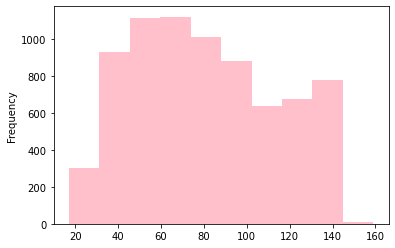

In [25]:
length_train = distinct_Tweets['TweetsText'].str.len().plot.hist(color = 'pink', figsize = (6, 4))

In [26]:
Tweet_count =distinct_Tweets['Status'].value_counts()
Tweet_count

off-topic    3773
on-topic     3693
Name: Status, dtype: int64

Text(0.5, 1.0, 'CLASS DISTRIBUTION: ON-Topic vs OFF-Topic')

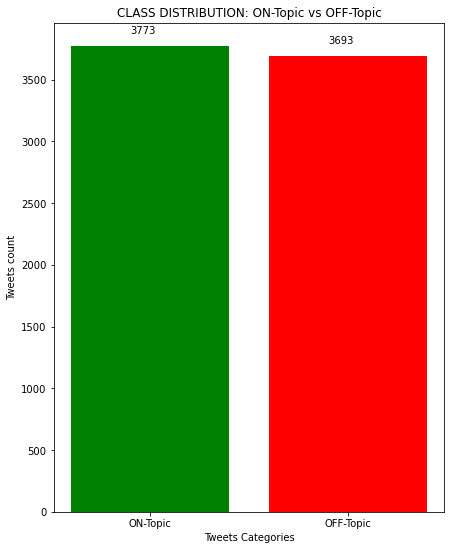

In [27]:
plt.figure(figsize = (7,9))
plt.bar(['ON-Topic', 'OFF-Topic'], Tweet_count.values, color = ['g', 'r'])
for i, v in enumerate(Tweet_count.values):
    plt.text(i - 0.1, v + 100, str(v))
plt.xlabel("Tweets Categories")
plt.ylabel("Tweets count")
plt.title("CLASS DISTRIBUTION: ON-Topic vs OFF-Topic")

In [ ]:
#ANALYSIS OF SENTIMENT FEATURES

In [40]:
processing_Data=distinct_Tweets.copy()

In [41]:
processing_Data['TweetsText']=processing_Data['TweetsText'].apply(process_tweet) # Cleaning the Tweets

In [ ]:
# One hot-encoding to change the label/category to numeric

In [42]:
processing_Data.loc[processing_Data['Status']=='off-topic','Status']=0
processing_Data.loc[processing_Data['Status']=='on-topic','Status']=1

In [44]:
# Comparing the out of the encoding to confirm it talllies with Cell 26(Distinct tweets)
print("Total distinct tweets in the dataset: {}".format(processing_Data.shape[0]))
Tweet_count = processing_Data['Status'].value_counts()
Tweet_count

Total distinct tweets in the dataset: 7466


0    3773
1    3693
Name: Status, dtype: int64

In [ ]:
#Drop Columns not needed for Predictions

In [45]:
processing_Data.drop(['TweetsID'], axis = 1, inplace = True)

In [46]:
processing_Data.head(3)

,TweetsText,Status
0,i've got enough candles to supply a mexican fa...,0
1,sandy be soooo mad that she be shattering our ...,1
2,USER_MENTION thankfully hurricane waugh played...,0


# Splitting to Train and Test Data

In [48]:
dF_features=processing_Data['TweetsText']
dF_target=processing_Data['Status']

In [49]:
X_train, x_test, y_train, y_test = train_test_split(dF_features, dF_target, test_size=0.2, random_state=11)

In [50]:
y_train=y_train.astype('int')
expected=y_test=y_test.astype('int')

In [ ]:
# Proper labelling of Training and Test Datasets

In [51]:
print()
train_dataset = pd.DataFrame({'TweetsText': X_train,'Category': y_train})
print(colored("Percentage of training dataset is : %.1f%%" % (len(train_dataset)/len(processing_Data)*100),"green"))
print(train_dataset['Category'].value_counts())
print()


test_dataset = pd.DataFrame({'TweetsText': x_test,'Category': y_test})
print(colored("Percentage of testing dataset is: %.1f%%" % (len(test_dataset)/len(processing_Data)*100),"green"))
print(test_dataset['Category'].value_counts())

train_tweet_label =train_dataset['Category'].astype('int')
test_tweet_label = test_dataset['Category'].astype('int')


Percentage of training dataset is : 80.0%
0    2989
1    2983
Name: Category, dtype: int64

Percentage of testing dataset is: 20.0%
0    784
1    710
Name: Category, dtype: int64


# Performing Features Extraction

In [52]:
features_Extractor=TfidfVectorizer(analyzer=lemmatize_func,min_df=1,stop_words=STOPWORDS)

In [53]:
train_tweet_vector =features_Extractor.fit_transform(train_dataset['TweetsText'])
test_tweet_vector = features_Extractor.transform(test_dataset['TweetsText'])

# Creating and Training the Models

In [54]:
MNB_estimator = classifier(MultinomialNB(),train_tweet_vector,train_tweet_label,test_tweet_vector) #MNB_estimator

In [55]:
decisionTree_estimator=classifier(DecisionTreeClassifier(),train_tweet_vector,train_tweet_label,test_tweet_vector) #decisionTree_estimator

# Model Evaluation:

# Accuracy Scores

In [65]:
accuracy()   

       MultinomialNB: accuracy score=79.72%; 
        DecisionTree: accuracy score=88.89%; 


# Classification_Reports

In [64]:
classification_Reports()

       MultinomialNB: classification_report
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       784
           1       0.74      0.89      0.81       710

    accuracy                           0.80      1494
   macro avg       0.81      0.80      0.80      1494
weighted avg       0.81      0.80      0.80      1494

        DecisionTree: classification_report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       784
           1       0.87      0.92      0.89       710

    accuracy                           0.90      1494
   macro avg       0.90      0.90      0.90      1494
weighted avg       0.90      0.90      0.90      1494



# Cross Validation using 10 folds

In [61]:
validation_Report()  #Cross Validation using 10 folds

       MultinomialNB: mean accuracy=82.00%; standard deviation=2.18%
        DecisionTree: mean accuracy=89.79%; standard deviation=1.67%


# Confusion_Matrix

       MultinomialNB: confusion matrix score
[[558 226]
 [ 77 633]]

        DecisionTree: confusion matrix score
[[682 102]
 [ 63 647]]



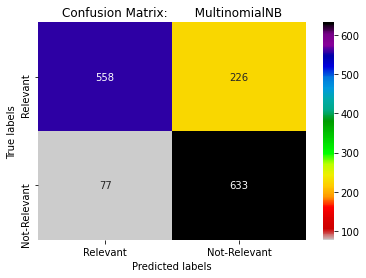

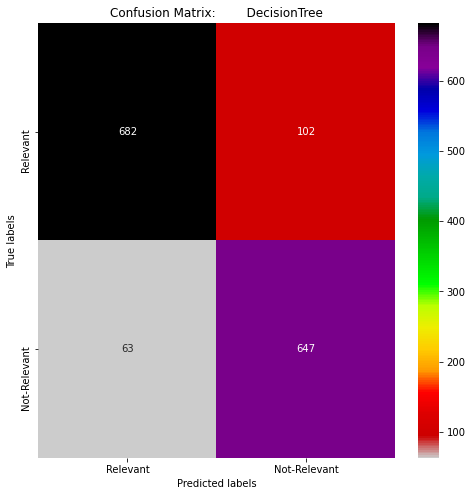

<Figure size 576x576 with 0 Axes>

In [62]:
confusion_Matrix()

# AUC ROC

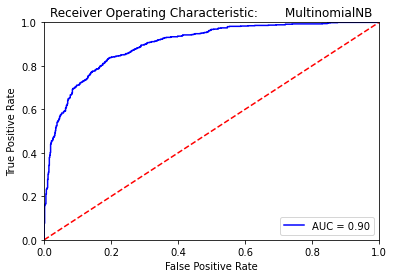

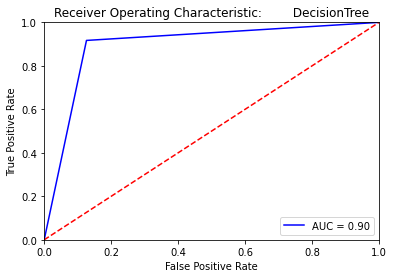

In [66]:
plot_roc_curve()

# Pre-Processing functions

In [ ]:
# 1.User defined functuions to replace Emoji`s found in tweets

In [28]:
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

In [ ]:
# 2.User defined functuions to remove noise from tweets

In [29]:
def process_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', 'RT', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()
    return ' '.join(words)

In [ ]:
# 3.User defined functuions to tokennize tweets

In [30]:
def lemmatize_func(tweets):
    tweets_Text=tweets.lower()
    words = word_tokenize(tweets_Text)
    valid_Words=[]
    for word in words :
        if word in STOPWORDS:continue
        valid_Words.append(word)
    return [lemma.lemmatize(word) for word in valid_Words]

In [ ]:
# 4.User defined Dynamic Estimators/Classifiers

In [31]:
def classifier(estimator,training_features,training_labels,test_features):
    estimator_object = estimator
    estimator_object.fit(training_features, training_labels)
    predicted= estimator_object.predict(test_features)
    return predicted

In [ ]:
# 5.User defined enumerator to group classif

In [32]:
estimators = {
    'MultinomialNB': MultinomialNB(),
     'DecisionTree': DecisionTreeClassifier()
}

In [33]:
def validation_Report():
    for estimator_name, estimator_object in estimators.items():
        kfold = KFold(n_splits=10, random_state=7, shuffle=True)
        scores = cross_val_score(estimator=estimator_object,
        X=train_tweet_vector, y=train_tweet_label, cv=kfold)
        print(colored(f'{estimator_name:>20}: ' +
        f'mean accuracy={scores.mean():.2%}; ' +
        f'standard deviation={scores.std():.2%}',"green"))

In [35]:
def accuracy():
    for estimator_name, estimator_object in estimators.items():
        model=estimator_object
        model.fit(train_tweet_vector,train_tweet_label)
        scores =model.score(test_tweet_vector, test_tweet_label)
        print(f'{estimator_name:>20}: ' +
        f'accuracy score={scores:.2%}; ')

In [36]:
def confusion_Matrix():
    for estimator_name, estimator_object in estimators.items():
        model=estimator_object
        confusion = confusion_matrix(test_tweet_label, classifier(model,train_tweet_vector,train_tweet_label,test_tweet_vector))
        print(colored(f'{estimator_name:>20}: ' +
        f'confusion matrix score',"green"))
        print(confusion)
        confusion_df = pd.DataFrame(confusion, index=range(2),columns=range(2))
        print()
        ax= plt.subplot()
        sns.heatmap(confusion_df, annot=True,ax=ax,cmap='nipy_spectral_r',fmt ='d') 
        plt.figure(figsize=(8, 8))
        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix:'f'{estimator_name:>20}'); 
        ax.xaxis.set_ticklabels(['Relevant', 'Not-Relevant']); ax.yaxis.set_ticklabels(['Relevant', 'Not-Relevant']);

In [38]:
def plot_roc_curve():
    for estimator_name, estimator_object in estimators.items():
        model=estimator_object
        model.fit(train_tweet_vector,train_tweet_label)
        preds = model.predict_proba(test_tweet_vector)[:,1]
        fpr, tpr, threshold = roc_curve(expected, preds)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic:'f'{estimator_name:>20}')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [39]:
def classification_Reports():
    for estimator_name, estimator_object in estimators.items():
        model=estimator_object
        class_reports = (classification_report(test_tweet_label, classifier(model,train_tweet_vector,train_tweet_label,test_tweet_vector)))
        #scores =model.score(test_tweet_vector, test_tweet_label)
        print(colored(f'{estimator_name:>20}: ' +
        f'classification_report',"green"))
        print(class_reports)